# Transformer Model

The first few steps in creating the training and test data and reshaping them are exactly the same as the LSTM models.

In [1]:
# import libraries

import numpy as np
import pandas as pd

In [2]:
#load the labelled data

data = pd.read_csv('./labelled_df.csv')
print(data.shape)

(2476065, 42)


In [3]:
# Count the no. of cases in each class
data['high_net_worth'].value_counts()/data.shape[0]

0    0.833325
1    0.166675
Name: high_net_worth, dtype: float64

In [4]:
data.columns

Index(['betTimestamp', 'odds_units', 'stake_gbp', 'count_legs',
       'hours_to_event', 'betDate', 'edge', 'encrypted_user_no', 'insert_date',
       'riskexposureprematch', 'betTimestamp_diff', 'odds_units_diff',
       'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
       'riskexposureprematch_diff', 'total_bets', 'avg_riskexposureprematch',
       'avg_odds_units', 'avg_stake_gbp', 'total_stake_gbp', 'month', 'day',
       'day_of_week', 'hour', 'bet_sequence_count', 'total_bets_in_sequence',
       'total_bets_until_now', 'avg_riskexposureprematch_until_now',
       'avg_odds_units_until_now', 'avg_count_legs_until_now',
       'avg_stake_gbp_until_now', 'total_stake_gbp_until_now',
       'std_stake_gbp_until_now', 'bets_in_last_1_week(s)',
       'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)',
       'bets_in_last_4_week(s)', 'num_sequences_until_now',
       'num_bets_in_prev_sequence', 'time_diff_of_riskexposure',
       'high_net_worth'],
      dtype='object'

In [5]:
# Select the features and target variable
features = ['odds_units', 'stake_gbp', 'count_legs', 'hours_to_event',
            'betTimestamp_diff', 'odds_units_diff',
            'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
            'riskexposureprematch_diff',
       'total_bets_until_now',
       'avg_odds_units_until_now', 'avg_count_legs_until_now',
       'avg_stake_gbp_until_now', 'total_stake_gbp_until_now',
       'std_stake_gbp_until_now','bets_in_last_1_week(s)', 
            'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)', 
            'bets_in_last_4_week(s)']



X = data.loc[:, features]
y = data['high_net_worth'].values

In [6]:
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(X, y, data['encrypted_user_no'])
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, data['encrypted_user_no'])):
    if i == 0:
        best_train = train_index
        best_test = test_index
        trp = sum(y[train_index]==1)/len(train_index)
        tep = sum(y[test_index]==1)/len(test_index)
        bdiff = np.abs(trp-tep)
    else:
        trp = sum(y[train_index]==1)/len(train_index)
        tep = sum(y[test_index]==1)/len(test_index)
        tdiff = np.abs(trp-tep)
        if tdiff < bdiff:
            best_train = train_index
            best_test = test_index
            bdiff = tdiff
print(data.loc[best_train,'high_net_worth'].value_counts()/len(best_train))
print(data.loc[best_test,'high_net_worth'].value_counts()/len(best_test))

0    0.830962
1    0.169038
Name: high_net_worth, dtype: float64
0    0.842781
1    0.157219
Name: high_net_worth, dtype: float64


In [7]:
#Split the data for trainining/test

# create seperate arrays to store user_ids to use for model analysis

X_train = X.loc[best_train,:]
y_train = y[best_train]
X_test = X.loc[best_test, :]
y_test = y[best_test]

# Extracting and saving 'encrypted_user_no' from train and test
#users_train = X_train['encrypted_user_no'].values
#users_test = X_test['encrypted_user_no'].values

# Dropping 'encrypted_user_no' from X_train and X_test
#X_train = X_train.drop(columns=['encrypted_user_no']).values
#X_test = X_test.drop(columns=['encrypted_user_no']).values

In [8]:
from tqdm import tqdm



#Reshape Train and test data to make them suitable for LSTM with timesteps of 10
def generate_sequences(data, sequence_length=10):
    sequences = []
    target_sequences = []
    seq_index=[]
    
    # Group by user and iterate over groups instead of filtering
    sorted_data = data.sort_values(['encrypted_user_no', 'total_bets_until_now'])
    users = sorted_data['encrypted_user_no'].unique()
    
    for user in tqdm(users):
        user_data = sorted_data.loc[sorted_data['encrypted_user_no']==user,features].values
        user_targets = sorted_data.loc[sorted_data['encrypted_user_no']==user,'high_net_worth'].values
        user_indices = sorted_data.index[sorted_data['encrypted_user_no']==user].values
        for i in range(0, len(user_data) - sequence_length + 1):
            seq = user_data[i:i+sequence_length]
            
            # Add only if the sequence has the required length
            if len(seq) == sequence_length:
                sequences.append(seq)
                target_sequences.append(user_targets[i+sequence_length-1])
                seq_index.append(user_indices[i+sequence_length-1])
            
    return np.array(sequences), np.array(target_sequences), seq_index

# Generate sequences for training and test data
X_train_sequences,y_train_sequences, train_seq_index = generate_sequences(data.loc[best_train, :])
X_test_sequences, y_test_sequences, test_seq_index = generate_sequences(data.loc[best_test, :])

# # Scale the sequences
# X_train_sequences_flat = X_train_sequences.reshape(-1, len(features))
# X_test_sequences_flat = X_test_sequences.reshape(-1, len(features))


# #Impute the missing data with mean
# imputer = SimpleImputer(strategy='mean')
# X_train_sequences_flat = imputer.fit_transform(X_train_sequences_flat)

# #You cannot impute the missing data using the test data, as that will include bias
# #But impute the test data after fitting the imputer with train data
# X_test_sequences_flat = imputer.transform (X_test_sequences_flat)

# scaler = StandardScaler()
# X_train_sequences_flat = scaler.fit_transform(X_train_sequences_flat)
# X_test_sequences_flat = scaler.transform(X_test_sequences_flat)

# # Reshape them back to sequences
# X_train_sequences = X_train_sequences_flat.reshape(-1, 10, len(features))
# X_test_sequences = X_test_sequences_flat.reshape(-1, 10, len(features))


100%|██████████| 2968/2968 [03:41<00:00, 13.38it/s]


In [9]:
# Scale the sequences
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

X_train_sequences_flat = X_train_sequences.reshape(-1, len(features))
X_test_sequences_flat = X_test_sequences.reshape(-1, len(features))


#Impute the missing data with mean
imputer = SimpleImputer(strategy='mean')
X_train_sequences_flat = imputer.fit_transform(X_train_sequences_flat)

#You cannot impute the missing data using the test data, as that will include bias
#But impute the test data after fitting the imputer with train data
X_test_sequences_flat = imputer.transform (X_test_sequences_flat)

scaler = StandardScaler()
X_train_sequences_flat = scaler.fit_transform(X_train_sequences_flat)
X_test_sequences_flat = scaler.transform(X_test_sequences_flat)

# Reshape them back to sequences
X_train_sequences = X_train_sequences_flat.reshape(-1, 10, len(features))
X_test_sequences = X_test_sequences_flat.reshape(-1, 10, len(features))

In [10]:
print(X_train_sequences.shape)
print(X_test_sequences.shape)

(1879495, 10, 20)
(469853, 10, 20)


# Using hyperparameter tuning

### Define a Transformer Encoder

This model processes a tensor of shape `(batch size, sequence length, features)`, where `sequence length` is the number of time steps and `features` is each input timeseries.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, neurons, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(neurons, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

2023-09-09 03:38:38.852999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can stack multiple of those `transformer_encoder` blocks and we can also proceed to add the final Multi-Layer Perceptron classification head. Apart from a stack of `Dense` layers, we need to reduce the output tensor of the `TransformerEncoder` part of our model down to a vector of features for each data point in the current batch. A common way to achieve this is to use a pooling layer. A `GlobalAveragePooling1D` layer is sufficient.

In [12]:
def build_model(input_shape, head_size, num_heads,neurons,num_transformer_blocks,mlp_units,dropout=0,mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, neurons, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import HyperModel, RandomSearch
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

input_shape = X_train_sequences.shape[1:]

# Define the HyperModel class
class TransformerHyperModel(HyperModel):

    def build(self, hp):
        head_size = hp.Int('head_size', min_value=64, max_value=512, step=64)
        num_heads = hp.Int('num_heads', 2, 4)
        neurons = hp.Int('neurons', min_value=64, max_value=512, step=64)
        num_transformer_blocks = hp.Int('num_transformer_blocks', 1, 3)
        mlp_units = [hp.Int('mlp_units_' + str(i), 64, 1024, step=64) for i in range(hp.Int('num_mlp_layers', 1, 3))]
        dropout = hp.Float('dropout', 0, 0.5, step=0.05)
        mlp_dropout = hp.Float('mlp_dropout', 0, 0.5, step=0.05)
        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

        model = build_model(input_shape, head_size, num_heads, neurons, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
        model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=learning_rate), metrics=['accuracy'])
        return model

# Training the model
tuner = RandomSearch(
    TransformerHyperModel(),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory='transformer_tuning_timesteps', 
    project_name='hnetworth'
)

tuner.search_space_summary()

Search space summary
Default search space size: 9
head_size (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
num_heads (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
neurons (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
num_transformer_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
num_mlp_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
mlp_units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
mlp_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'st

In [19]:
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

# Shuffle the data
X_train_sequences, y_train_sequences = shuffle(X_train_sequences, y_train_sequences, random_state=42)

# Select 10% of the data
sample_size = int(0.1 * len(X_train_sequences))
X_train_subsample = X_train_sequences[:sample_size]
y_train_subsample = y_train_sequences[:sample_size]

filepath = 'best_tuning_transformer.hdf5'

estopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)


tuner.search(X_train_subsample, y_train_subsample, epochs=10, batch_size=256, validation_split=0.05, callbacks=[checkpoint, estopping]) 

Trial 5 Complete [00h 19m 44s]
val_accuracy: 0.937380313873291

Best val_accuracy So Far: 0.937380313873291
Total elapsed time: 04h 00m 15s
INFO:tensorflow:Oracle triggered exit


In [20]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Extracting the mlp_units
num_mlp_layers = best_hps.get('num_mlp_layers')
mlp_units_values = [best_hps.get(f"mlp_units_{i}") for i in range(num_mlp_layers)]

print(f"""
The optimal head_size is {best_hps.get('head_size')} and the optimal number of heads is {best_hps.get('num_heads')}.
The optimal neurons is {best_hps.get('neurons')}, and the optimal number of transformer blocks is {best_hps.get('num_transformer_blocks')}.
The optimal mlp_units are {mlp_units_values}, with a dropout of {best_hps.get('dropout')} and an mlp_dropout of {best_hps.get('mlp_dropout')}.
The learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")



The optimal head_size is 64 and the optimal number of heads is 2.
The optimal neurons is 320, and the optimal number of transformer blocks is 2.
The optimal mlp_units are [1024, 576], with a dropout of 0.0 and an mlp_dropout of 0.45.
The learning rate for the optimizer is 0.0017308008389249545.



In [21]:
# Rebuild the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 20)]     0           []                               
                                                                                                  
 layer_normalization_4 (LayerNo  (None, 10, 20)      40          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 10, 20)      10644       ['layer_normalization_4[0][0]',  
 eadAttention)                                                    'layer_normalization_4[0][0]']  
                                                                                            

In [22]:
# Train model on entire training dataset
filepath_final = 'transformer_model_best.hdf5'

checkpoint_final = ModelCheckpoint(filepath_final, monitor='val_accuracy', verbose=1, save_best_only=True)

history = model.fit(X_train_sequences, y_train_sequences, epochs=15, batch_size=256, validation_split=0.1, callbacks=[checkpoint_final, estopping]) 


Epoch 1/15
6607/6608 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.9259
Epoch 1: val_accuracy improved from -inf to 0.92876, saving model to transformer_model_best.hdf5
6608/6608 [==============================] - 502s 75ms/step - loss: 0.1909 - accuracy: 0.9259 - val_loss: 0.1851 - val_accuracy: 0.9288
Epoch 2/15
6608/6608 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9341
Epoch 2: val_accuracy improved from 0.92876 to 0.93276, saving model to transformer_model_best.hdf5
6608/6608 [==============================] - 567s 86ms/step - loss: 0.1772 - accuracy: 0.9341 - val_loss: 0.1648 - val_accuracy: 0.9328
Epoch 3/15
6608/6608 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9317
Epoch 3: val_accuracy did not improve from 0.93276
6608/6608 [==============================] - 639s 97ms/step - loss: 0.1911 - accuracy: 0.9317 - val_loss: 0.2180 - val_accuracy: 0.9316
Epoch 4/15
6608/6608 [============================

In [23]:
# Evaluation
from sklearn.metrics import classification_report, accuracy_score
y_prob = model.predict(X_test_sequences)
y_pred = (y_prob>0.5).astype(int)
accuracy = accuracy_score(y_test_sequences, y_pred)
classification_rep = classification_report(y_test_sequences, y_pred)

print("Accuracy on Test Set:", accuracy)
print("Classification Report:\n", classification_rep)

14683/14683 [==============================] - 68s 5ms/step
Accuracy on Test Set: 0.8562103466403322
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92    392112
           1       0.99      0.13      0.23     77741

    accuracy                           0.86    469853
   macro avg       0.92      0.57      0.58    469853
weighted avg       0.88      0.86      0.81    469853



In [24]:
# Compute and display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_sequences, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[391956    156]
 [ 67404  10337]]


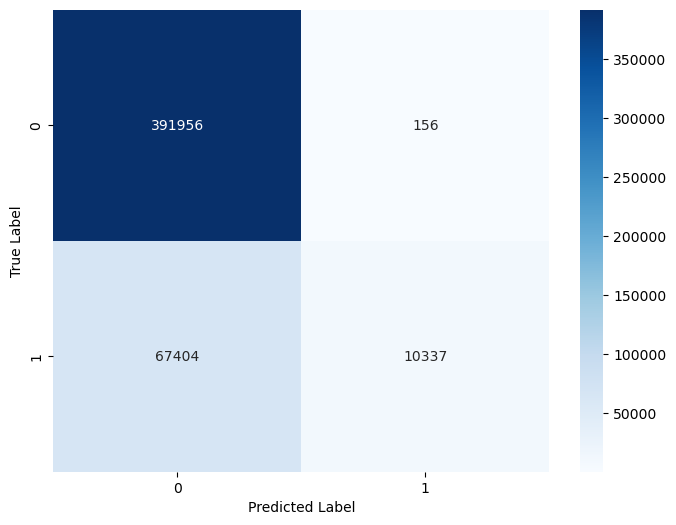

In [25]:
# Plot the confusion matrix for better visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Analysing results

In [26]:
#Predict for the test data and merge the predicted values with the original data
data_test=data.loc[test_seq_index,:].copy()
y_pred = model.predict(X_test_sequences).astype(int)
data_test['y_pred'] = y_pred

14683/14683 [==============================] - 93s 6ms/step


### Accuracy vs number of bets

In [27]:
# Create a column of 0 and 1 if correctly predicted
data_test['pred_correct']=(data_test['y_pred']==data_test['high_net_worth'])

#Group the data by total number of bets and for each number of bets compute accuracy
accgroup = data_test.groupby('total_bets_until_now')['pred_correct'].mean()
accgroup=accgroup.reset_index()

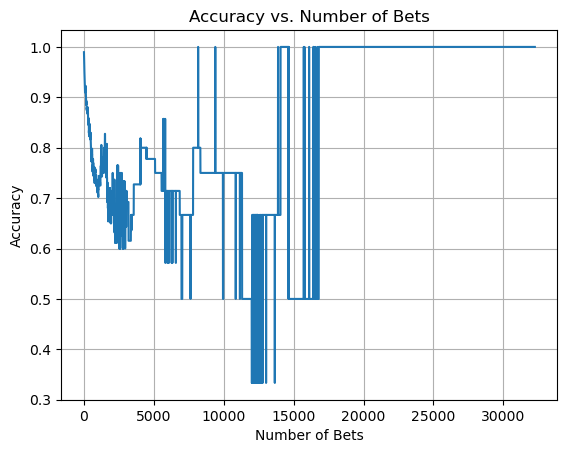

In [28]:
# Visualize accuracy against the numb er of bets
plt.plot(accgroup['total_bets_until_now'], accgroup['pred_correct'])
plt.xlabel('Number of Bets')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Bets')
plt.grid(True)
plt.show()

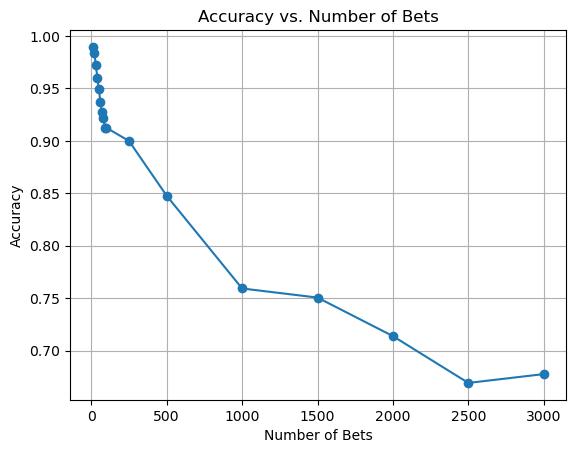

In [29]:
#Discretize the number of bets into bins and then visualize the 
#accuracy against the number of bets in each category

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000],
                           labels=[10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000])

accgroup2 = data_test.groupby('n_bets')['pred_correct'].mean()
accgroup2=accgroup2.reset_index()

# Visualize
plt.plot(accgroup2['n_bets'], accgroup2['pred_correct'],marker='o')
plt.xlabel('Number of Bets')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Bets')
#plt.xlim([0,100])
plt.grid(True)
plt.show()

### Precision vs number of bets

In [30]:
# Create columns for True Positives (TP), False Positives (FP) and False Negatives (FN)
data_test['TP'] = ((data_test['y_pred'] == 1) & (data_test['high_net_worth'] == 1)).astype(int)
data_test['FP'] = ((data_test['y_pred'] == 1) & (data_test['high_net_worth'] == 0)).astype(int)
data_test['FN'] = ((data_test['y_pred'] == 0) & (data_test['high_net_worth'] == 1)).astype(int)

#Group the data by total number of bets and for each number of bets compute TP and FP
prec_group = data_test.groupby('total_bets_until_now').agg({'TP': 'sum', 'FP': 'sum'})
prec_group=prec_group.reset_index()

In [31]:
# Compute precision for each group
prec_group['Precision'] = prec_group['TP'] / (prec_group['TP'] + prec_group['FP'])

# Handle NaN/Inf values if any (e.g., when both TP and FP are zero)
prec_group['Precision'].replace({np.inf: 0, np.nan: 0}, inplace=True)

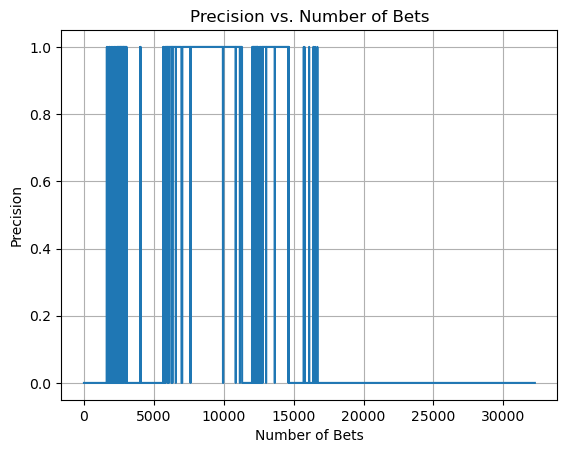

In [32]:
# Visualize precision against the number of bets
plt.plot(prec_group['total_bets_until_now'], prec_group['Precision'])
plt.xlabel('Number of Bets')
plt.ylabel('Precision')
plt.title('Precision vs. Number of Bets')
plt.grid(True)
plt.show()

/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_740/413561989.py:8: RuntimeWarning: invalid value encountered in long_scalars
  precision_group = data_test.groupby('n_bets').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FP'].sum())).reset_index()


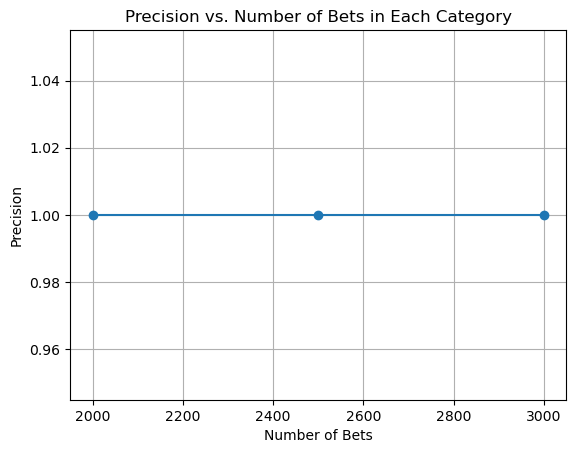

In [33]:
#Discretize the number of bets into bins and then visualize the 
#accuracy against the number of bets in each category

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000],
                           labels=[10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000])

# Group by number of bets category and compute precision
precision_group = data_test.groupby('n_bets').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FP'].sum())).reset_index()
precision_group.columns = ['n_bets', 'precision']

# Visualize
plt.plot(precision_group['n_bets'], precision_group['precision'], marker='o')
plt.xlabel('Number of Bets')
plt.ylabel('Precision')
plt.title('Precision vs. Number of Bets in Each Category')
plt.grid(True)
plt.show()                

### Recall vs number of bets

In [34]:
# Group by total number of bets and compute recall
recall_group = data_test.groupby('total_bets_until_now').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FN'].sum())).reset_index()
recall_group.columns = ['total_bets_until_now', 'recall']

/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_740/3103329723.py:2: RuntimeWarning: invalid value encountered in long_scalars
  recall_group = data_test.groupby('total_bets_until_now').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FN'].sum())).reset_index()


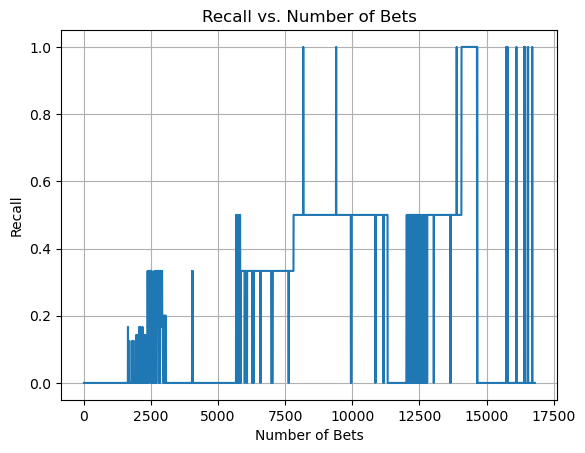

In [35]:
# Visualize recall against the number of bets
plt.plot(recall_group['total_bets_until_now'], recall_group['recall'])
plt.xlabel('Number of Bets')
plt.ylabel('Recall')
plt.title('Recall vs. Number of Bets')
plt.grid(True)
plt.show()

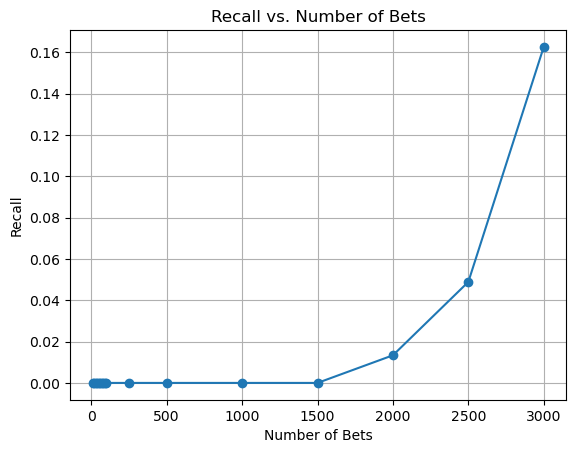

In [36]:
#Discretize the number of bets into bins and then visualize the 
#accuracy against the number of bets in each category

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000],
                           labels=[10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000])

# Group by the number of bets bin and compute recall for each bin
recall_group2 = data_test.groupby('n_bets').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FN'].sum())).reset_index()
recall_group2.columns = ['n_bets', 'recall']

# Visualize recall against the number of bets for each bin
plt.plot(recall_group2['n_bets'], recall_group2['recall'], marker='o')
plt.xlabel('Number of Bets')
plt.ylabel('Recall')
plt.title('Recall vs. Number of Bets')
plt.grid(True)
plt.show()
                             

### Proportion of HNW

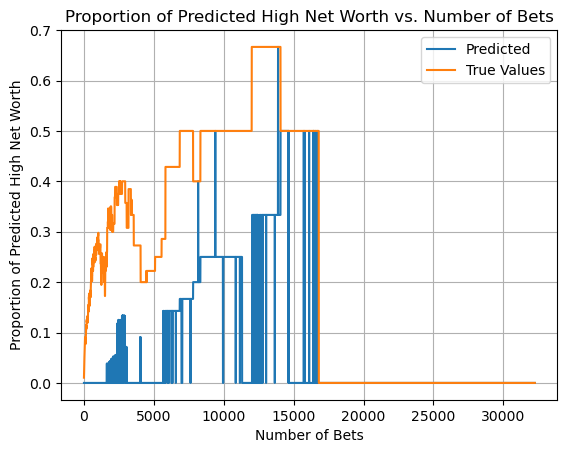

In [37]:
# create proportion of true and predicted high_net_worth for each number of bets and then visualize

predgroup = data_test.groupby('total_bets_until_now')[['high_net_worth','y_pred']].mean()
predgroup = predgroup.reset_index()

# Visualize
plt.plot(predgroup['total_bets_until_now'], predgroup['y_pred'],label='Predicted')
plt.plot(predgroup['total_bets_until_now'], predgroup['high_net_worth'],label='True Values')
plt.xlabel('Number of Bets')
plt.ylabel('Proportion of Predicted High Net Worth')
plt.title('Proportion of Predicted High Net Worth vs. Number of Bets')
plt.legend()
plt.grid(True)
plt.show()

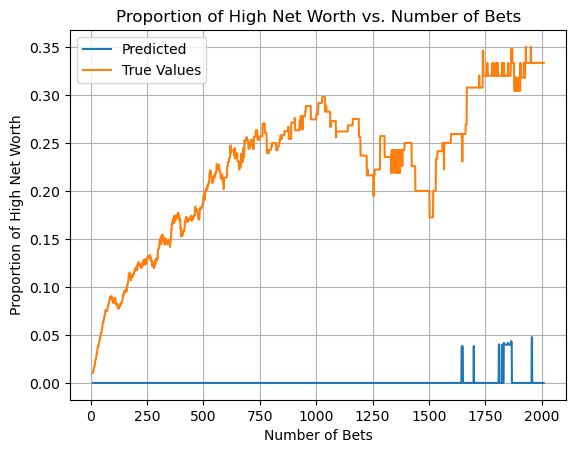

In [38]:
# Visualize the same as above when number of bets is upto 2000.
plt.plot(predgroup['total_bets_until_now'][:2000], predgroup['y_pred'][:2000],label='Predicted')
plt.plot(predgroup['total_bets_until_now'][:2000], predgroup['high_net_worth'][:2000],label='True Values')
plt.xlabel('Number of Bets')
plt.ylabel('Proportion of High Net Worth')
plt.title('Proportion of High Net Worth vs. Number of Bets')
plt.legend()
plt.grid(True)
plt.show()

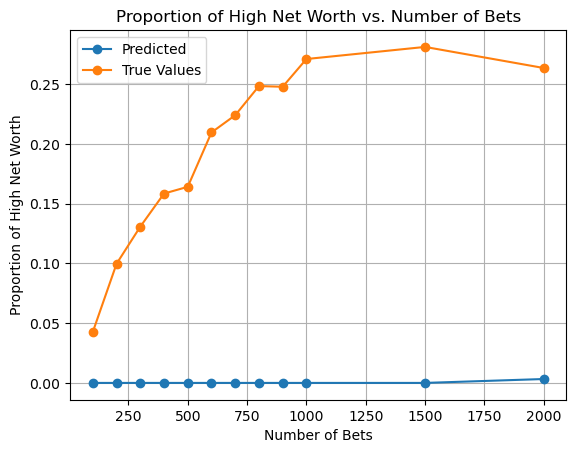

In [39]:
# create proportion of true and predicted high_net_worth for each number of bets and user and then visualize

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,100,200,300,400,500,600,700,800,900,1000,1500, 2000],
                           labels=[100,200,300,400,500,600,700,800,900,1000,1500,2000])
predgroup2 = data_test.groupby(['encrypted_user_no','n_bets'])[['high_net_worth','y_pred']].mean()
predgroup2 = predgroup2.reset_index()
predgroup3 = predgroup2.groupby(['n_bets'])[['high_net_worth','y_pred']].mean()
predgroup3 = predgroup3.reset_index()

# Visualize
#predgroup2.plot.bar('n_bets', ['high_net_worth','y_pred'])
plt.plot(predgroup3['n_bets'], predgroup3['y_pred'],marker='o',label='Predicted')
plt.plot(predgroup3['n_bets'], predgroup3['high_net_worth'],marker='o', label='True Values')
plt.xlabel('Number of Bets')
plt.ylabel('Proportion of High Net Worth')
plt.title('Proportion of High Net Worth vs. Number of Bets')
plt.legend()
plt.grid(True)
plt.show()

### Num bets before label change

In [40]:
#Bets before change for each user
data_test = data_test.sort_values(['encrypted_user_no','total_bets_until_now'])
data_test['y_diffs'] = data_test['high_net_worth'].diff()
data_test['ypred_diffs'] = data_test['y_pred'].diff()

mask = (data_test['encrypted_user_no'] != data_test['encrypted_user_no'].shift(1) )
data_test.loc[mask,'y_diffs'] = np.nan
data_test.loc[mask,'ypred_diffs'] = np.nan

bet_changey=data_test.index[np.where(data_test.y_diffs==1)[0]]
bet_changeyp=data_test.index[np.where(data_test.ypred_diffs==1)[0]]


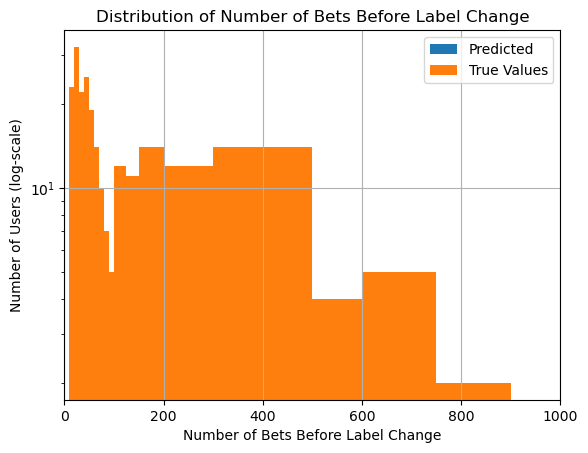

In [41]:
# Visualize
bins = [0,10,20,30,40,50,60,70,80,90,100,125, 150, 200,300,500,600,750,900,1000]
ax=data_test.loc[bet_changeyp,:].hist('total_bets_until_now',bins=bins,label='Predicted')
data_test.loc[bet_changey,:].hist('total_bets_until_now',bins=bins,ax=ax,label='True Values')

plt.xlim([0,1000])
# Labels and title
plt.yscale('log')
plt.xlabel('Number of Bets Before Label Change')
plt.ylabel('Number of Users (log-scale)')
plt.title('Distribution of Number of Bets Before Label Change')
plt.legend()
plt.grid(True)
plt.show()

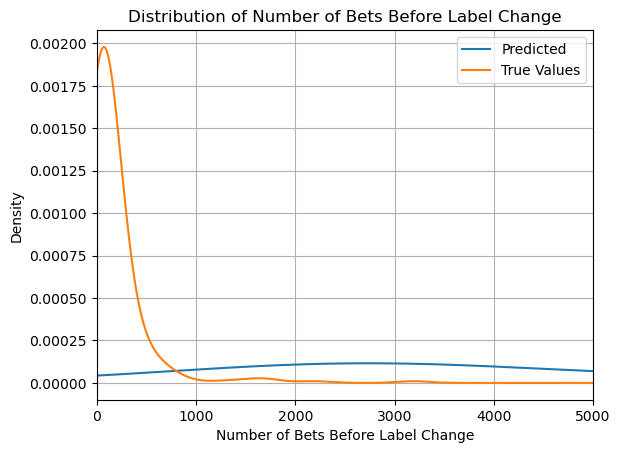

In [42]:
ax=data_test.loc[bet_changeyp,'total_bets_until_now'].plot.density(label='Predicted')
data_test.loc[bet_changey,'total_bets_until_now'].plot.density(ax=ax,label='True Values')

plt.xlim([0,5000])
plt.xlabel('Number of Bets Before Label Change')
plt.ylabel('Density')
plt.title('Distribution of Number of Bets Before Label Change')
plt.legend()
plt.grid(True)
plt.show()